# TensorFlow image recognition

## Setup 

In [1]:
import numpy as np
import pandas as pd
import os
import PIL
import PIL.Image
import tensorflow as tf
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from itertools import cycle
from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
from sklearn.metrics import roc_auc_score

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

2023-12-18 14:40:11.341665: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# check tensorflow version
print(tf.__version__)

2.14.0


In [3]:
# define training and validation directories and filenames

# training white move
train_white_dir = os.path.join('./data-train/white-move')
train_white_names = os.listdir(train_white_dir)

# training black move
train_black_dir = os.path.join('./data-train/black-move')
train_black_names = os.listdir(train_black_dir)

# validation white move
valid_white_dir = os.path.join('./data-validation/white-move')
valid_white_names = os.listdir(valid_white_dir)

# validation black move
valid_black_dir = os.path.join('./data-validation/black-move')
valid_black_names = os.listdir(valid_black_dir)

In [4]:
# take a peek at the filenames
train_white_names = os.listdir(train_white_dir)
print(train_white_names[:3])

['111.jpeg', '201.jpeg', '77.jpeg']


In [5]:
# # Take a look at the pics
# # Parameters for our graph; we'll output images in a 4x4 configuration
# nrows = 4
# ncols = 4

# # Index for iterating over images
# pic_index = 0

# # Set up matplotlib fig, and size it to fit 4x4 pics
# fig = plt.gcf()
# fig.set_size_inches(ncols * 4, nrows * 4)

# pic_index += 8
# next_white_pic = [os.path.join(train_white_dir, fname) 
#                 for fname in train_white_names[pic_index-8:pic_index]]
# next_black_pic = [os.path.join(train_black_dir, fname) 
#                 for fname in train_black_names[pic_index-8:pic_index]]

# for i, img_path in enumerate(next_white_pic + next_black_pic):
#   # Set up subplot; subplot indices start at 1
#   sp = plt.subplot(nrows, ncols, i+1)
#   sp.axis('Off') # Don't show axes (or gridlines)

#   img = mpimg.imread(img_path)
#   plt.imshow(img)

# plt.show()

## Data processing

In [6]:
# define classes
classes = ['white-move', 'black-move']

# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(rescale=1/255)
validation_datagen = ImageDataGenerator(rescale=1/255)

# Flow training images in batches of 16 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
        './data-train/',  # This is the source directory for training images
        classes = classes,
        target_size=(200, 200),  # All images will be resized to 200x200
        batch_size=8,
        # Use binary labels
        class_mode='binary')

# Flow validation images in batches of 2 using valid_datagen generator
validation_generator = validation_datagen.flow_from_directory(
        './data-validation/',  # This is the source directory for training images
        classes = classes,
        target_size=(200, 200),  # All images will be resized to 200x200
        batch_size=4,
        # Use binary labels
        class_mode='binary',
        shuffle=False)

Found 525 images belonging to 2 classes.
Found 130 images belonging to 2 classes.


## Building model from scratch

In [7]:
# define the model
model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape = (200,200,3)), 
    tf.keras.layers.Dense(256, activation=tf.nn.relu),
    tf.keras.layers.Dense(256, activation=tf.nn.relu),
    tf.keras.layers.Dense(256, activation=tf.nn.relu),
    tf.keras.layers.Dense(256, activation=tf.nn.relu),
    tf.keras.layers.Dense(1, activation=tf.nn.sigmoid)
])

In [8]:
# compile the model
model.compile(optimizer = tf.optimizers.Adam(),
              loss = 'binary_crossentropy',
              metrics=['binary_accuracy'])

In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 120000)            0         
                                                                 
 dense (Dense)               (None, 256)               30720256  
                                                                 
 dense_1 (Dense)             (None, 256)               65792     
                                                                 
 dense_2 (Dense)             (None, 256)               65792     
                                                                 
 dense_3 (Dense)             (None, 256)               65792     
                                                                 
 dense_4 (Dense)             (None, 1)                 257       
                                                                 
Total params: 30917889 (117.94 MB)
Trainable params: 309

In [10]:
history = model.fit(
      train_generator,
      steps_per_epoch=16,  
      epochs=50,
      verbose=1,
      validation_data = validation_generator,
      validation_steps=4)

Epoch 1/50
16/16 [==============================] - 4s 182ms/step - loss: 12.4315 - binary_accuracy: 0.4375 - val_loss: 0.0895 - val_binary_accuracy: 1.0000
Epoch 2/50
16/16 [==============================] - 3s 210ms/step - loss: 4.9052 - binary_accuracy: 0.5200 - val_loss: 0.0019 - val_binary_accuracy: 1.0000
Epoch 3/50
16/16 [==============================] - 3s 208ms/step - loss: 2.2332 - binary_accuracy: 0.5703 - val_loss: 0.1388 - val_binary_accuracy: 1.0000
Epoch 4/50
16/16 [==============================] - 3s 210ms/step - loss: 0.6807 - binary_accuracy: 0.6875 - val_loss: 0.4911 - val_binary_accuracy: 0.8125
Epoch 5/50
16/16 [==============================] - 3s 194ms/step - loss: 0.5038 - binary_accuracy: 0.7760 - val_loss: 1.2531 - val_binary_accuracy: 0.1875
Epoch 6/50
16/16 [==============================] - 3s 199ms/step - loss: 0.5454 - binary_accuracy: 0.7840 - val_loss: 2.6602 - val_binary_accuracy: 0.0000e+00
Epoch 7/50
16/16 [==============================] - 3s 193m

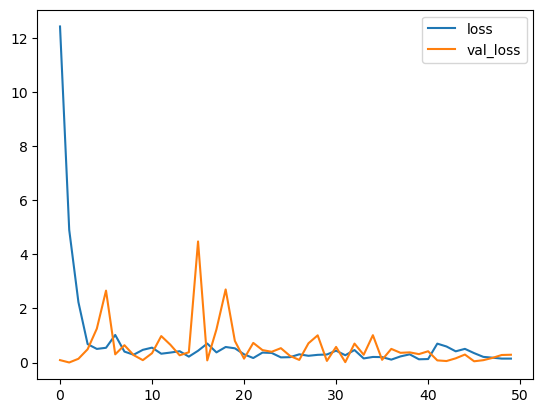

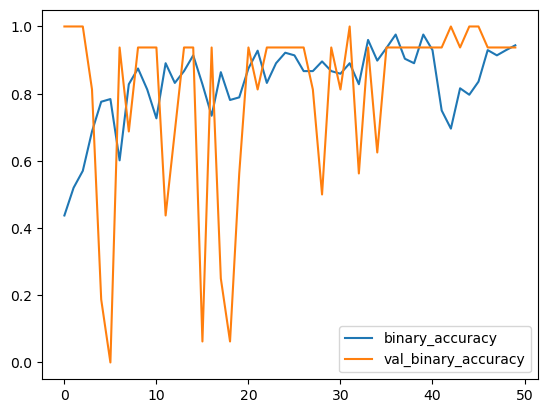

In [11]:
history_frame = pd.DataFrame(history.history)
history_frame.loc[:, ['loss', 'val_loss']].plot()
history_frame.loc[:, ['binary_accuracy', 'val_binary_accuracy']].plot();

## Accuracy, ROC Curve and AUC

In [12]:
# evaluate the accuracy of our model
model.evaluate(validation_generator)

33/33 [==============================] - 2s 46ms/step - loss: 0.5401 - binary_accuracy: 0.8615


[0.5400561094284058, 0.8615384697914124]

In [13]:
# calculate ROC curve
STEP_SIZE_TEST=validation_generator.n//validation_generator.batch_size
validation_generator.reset()
preds = model.predict(validation_generator,
                      verbose=1)

33/33 [==============================] - 1s 34ms/step


In [14]:
# create the ROC and AUC compute the false positive rate and the true positive rate
fpr, tpr, _ = roc_curve(validation_generator.classes, preds)

In [15]:
roc_auc = auc(fpr, tpr)

1/1 [==============================] - 0s 33ms/step
[[1.]]
./data-test/black-move/1.jpeg => BLACK to move!


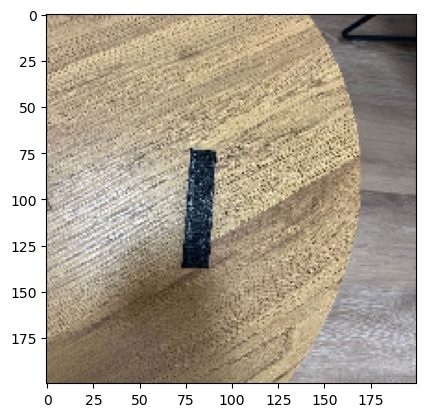

In [20]:
# predicting images
# ("black-move/1.jpeg", "white-move/1.jpeg"):

white_test = './data-test/white-move/1.jpeg'
black_test = './data-test/black-move/1.jpeg'

path = black_test
img = image.load_img(path, target_size=(200, 200))
x = image.img_to_array(img)
plt.imshow(x/255.)
x = np.expand_dims(x, axis=0)
images = np.vstack([x])
classes = model.predict(images, batch_size=10)
print(classes)
if classes[0]<0.5:
    print(path + " => WHITE to move!")
else:
    print(path + " => BLACK to move!")